In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import torch.nn.functional as F  # For softmax
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Allocate subsets
demographic_features = ['Specialty', 'PlaceSvc', 'AgeAtFirstClaim', 'Sex']
medical_history_features = ['DSFS_Claims', 'CharlsonIndex', 'PrimaryConditionGroup', 'ProcedureGroup', 'SupLOS', 
                            'PayDelay', 'LengthOfStay', 'DSFS_Drugs', 'DSFS_Lab', 'LabCount', 'ClaimsTruncated']
treatment_features = ['DrugCount', 'LabCount', 'DSFS_Drugs', 'DSFS_Lab']

In [48]:
# Load the data
train_data_df = pd.read_csv("../data/preprocessed/prp_combined_Y1.csv")
test_data_df = pd.read_csv("../data/preprocessed/prp_combined_Y2.csv")

scaler = MinMaxScaler()
# Normalize length of stay within CV loop
train_data_df['LengthOfStay'] = scaler.fit_transform(train_data_df[['LengthOfStay']])
test_data_df['LengthOfStay'] = scaler.transform(test_data_df[['LengthOfStay']])

# Prepare the data for training
X_train = torch.tensor((train_data_df.drop(["MemberID", "DaysInHospitalY2"], axis=1).values).astype(np.float32))
X_test = torch.tensor((test_data_df.drop(["MemberID", "DaysInHospitalY3"], axis=1).values).astype(np.float32))

# Extract the subsets of features
X_train_demographic = train_data_df[demographic_features]
X_train_medical_history = train_data_df[medical_history_features]
X_train_treatment = train_data_df[treatment_features]


# Convert to torch tensors
X_train_demographic = torch.tensor(X_train_demographic.values, dtype=torch.float32)
X_train_medical_history = torch.tensor(X_train_medical_history.values, dtype=torch.float32)
X_train_treatment = torch.tensor(X_train_treatment.values, dtype=torch.float32)


y_train = torch.tensor(train_data_df["DaysInHospitalY2"].values.astype(np.longlong))
y_test = torch.tensor(test_data_df["DaysInHospitalY3"].values.astype(np.longlong))

# Get the number of features and classes
n_samples, n_features = X_train.shape
n_classes = len(torch.unique(y_train))

In [4]:

# Define Logistic Regression model (multiclass)
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, n_outputs)

    def forward(self, x):
        return self.linear(x)  # raw logits, softmax will be applied in loss function



In [5]:
# Function for k fold 
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

In [6]:
from sklearn.metrics import precision_score, recall_score

In [8]:
# Manually calculate precision and recall
def calculate_precision_recall_manual(predicted, true_labels, n_classes):
    # Initialize lists to store precision and recall for each class
    precision_per_class = []
    recall_per_class = []
    
    # Loop over each class
    for class_idx in range(n_classes):
        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) for the current class
        TP = torch.sum((predicted == class_idx) & (true_labels == class_idx)).item()  
        FP = torch.sum((predicted == class_idx) & (true_labels != class_idx)).item()  
        FN = torch.sum((predicted != class_idx) & (true_labels == class_idx)).item()  
        
        # add small epsilon to avoid division by zero
        precision = TP / (TP + FP + 1e-10)
        precision_per_class.append(precision)
        
        recall = TP / (TP + FN + 1e-10)
        recall_per_class.append(recall)
        
    # Return the precision and recall for each class
    return precision_per_class, recall_per_class

In [9]:
# Training and validation function with different regularization parameters
def train_and_validate_with_regularization(X_train, y_train, model_class, criterion, num_epochs=100, num_folds=20, lr=0.01, regularization_params=[0.01, 0.1, 1, 10]):
    kf = kfold_indices(X_train, num_folds)
    
    results = {}

    n_features = X_train.size()[1]
    # Iterate over different regularization parameters (weight decay values)
    for reg_param in regularization_params:
        print(f"\nTraining with Regularization Parameter (Weight Decay): {reg_param}")

        # Store the final loss and accuracy at the end of each fold
        fold_losses = []
        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []
        fold_f1_scores = []
        
        # Cross-validation
        for fold, split in enumerate(kf):
            train_idx = split[0]
            val_idx = split[1]
            print(f"\nFold {fold + 1}/{num_folds}")
            train_data, val_data = X_train[train_idx], X_train[val_idx]
            train_labels, val_labels = y_train[train_idx], y_train[val_idx]

            # Initialize model and optimizer
            model = LogisticRegression(n_features, n_classes)
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_param)  # Apply regularization via weight decay
            
            for epoch in range(num_epochs):
                model.train()
                y_pred = model(train_data)
                loss = criterion(y_pred, train_labels)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # After completing all epochs, evaluate the model on the validation set
            model.eval()
            with torch.no_grad():
                val_preds = model(val_data)
                val_loss = criterion(val_preds, val_labels)

                # Compute accuracy
                _, predicted = torch.max(val_preds, 1)
                accuracy = (predicted == val_labels).float().mean().item()
                
                 # Calculate precision and recall
                precision_per_class, recall_per_class = calculate_precision_recall_manual(predicted, val_labels, n_classes)
                
                # Average precision and recall across all classes (macro average)
                avg_precision = sum(precision_per_class) / n_classes
                avg_recall = sum(recall_per_class) / n_classes
                
                # Calculate the F1 score using the macro average precision and recall
                avg_f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall + 1e-10)
                
                
                # # Compute precision and recall using sklearn functions
                # precision = precision_score(val_labels.cpu(), predicted.cpu(), average='macro', zero_division=0)
                # recall = recall_score(val_labels.cpu(), predicted.cpu(), average='macro', zero_division=0)

            # Store the final loss and accuracy for this fold
            fold_losses.append(val_loss.item())
            fold_accuracies.append(accuracy)
            fold_precisions.append(avg_precision)
            fold_recalls.append(avg_recall)
            fold_f1_scores.append(avg_f1_score)

            # Print the loss and accuracy for this fold
            print(f'Fold {fold + 1}, Final Loss: {val_loss.item():.4f}, Final Accuracy: {accuracy:.4f}, Final Precision: {avg_precision:.4f}, Final Recall: {avg_recall:.4f}')
        
        # Store results for the current regularization parameter
        results[reg_param] = {
            'fold_losses': fold_losses,
            'fold_accuracies': fold_accuracies,
            'fold_precisions': fold_precisions,
            'fold_recalls': fold_recalls,
            'fold_f1_scores': fold_f1_scores
        }

    return results

# Loss function
criterion = nn.CrossEntropyLoss()

# Regularization parameters to test (C = 1 / weight_decay)
regularization_params = [0.01, 0.1, 1, 10]  # Larger values mean stronger regularization

# Perform cross-validation for different regularization parameters
results_demographic = train_and_validate_with_regularization(X_train_demographic, y_train, LogisticRegression, criterion, num_epochs=100, num_folds=20, regularization_params=regularization_params)
results_medical_history = train_and_validate_with_regularization(X_train_medical_history, y_train, LogisticRegression, criterion, num_epochs=100, num_folds=20, regularization_params=regularization_params)
results_treatment = train_and_validate_with_regularization(X_train_treatment, y_train, LogisticRegression, criterion, num_epochs=100, num_folds=20, regularization_params=regularization_params)



Training with Regularization Parameter (Weight Decay): 0.01

Fold 1/20
Fold 1, Final Loss: 1.2300, Final Accuracy: 0.8110, Final Precision: 0.0526, Final Recall: 0.0600

Fold 2/20
Fold 2, Final Loss: 1.4864, Final Accuracy: 0.8313, Final Precision: 0.0523, Final Recall: 0.0620

Fold 3/20
Fold 3, Final Loss: 1.3485, Final Accuracy: 0.6944, Final Precision: 0.0532, Final Recall: 0.0579

Fold 4/20
Fold 4, Final Loss: 1.5803, Final Accuracy: 0.8492, Final Precision: 0.0531, Final Recall: 0.0625

Fold 5/20
Fold 5, Final Loss: 1.1683, Final Accuracy: 0.8239, Final Precision: 0.0523, Final Recall: 0.0615

Fold 6/20
Fold 6, Final Loss: 1.2358, Final Accuracy: 0.8347, Final Precision: 0.0525, Final Recall: 0.0620

Fold 7/20
Fold 7, Final Loss: 1.5900, Final Accuracy: 0.8455, Final Precision: 0.0528, Final Recall: 0.0625

Fold 8/20
Fold 8, Final Loss: 1.2059, Final Accuracy: 0.8394, Final Precision: 0.0531, Final Recall: 0.0617

Fold 9/20
Fold 9, Final Loss: 1.1021, Final Accuracy: 0.8489, Fina

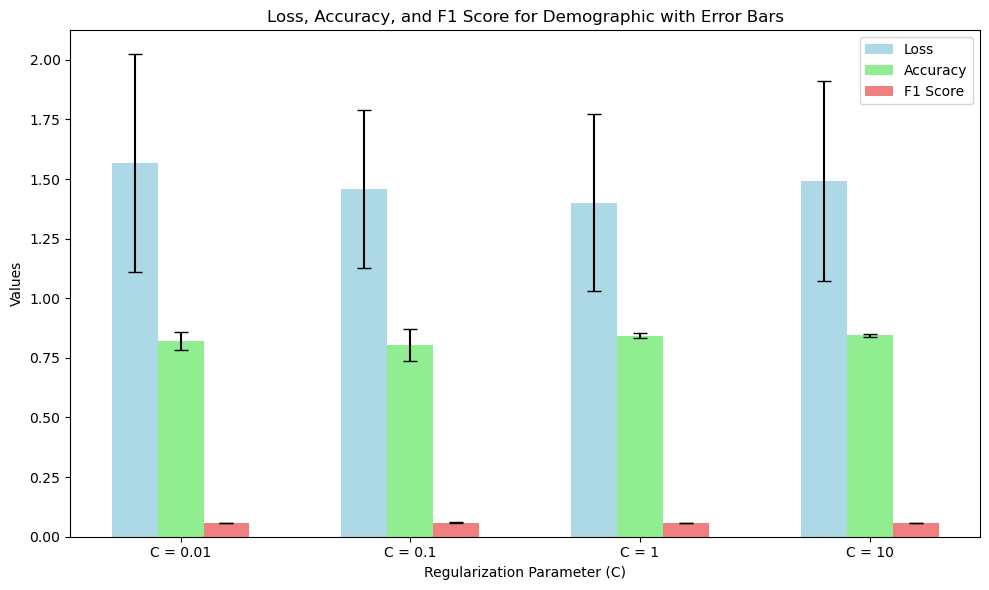

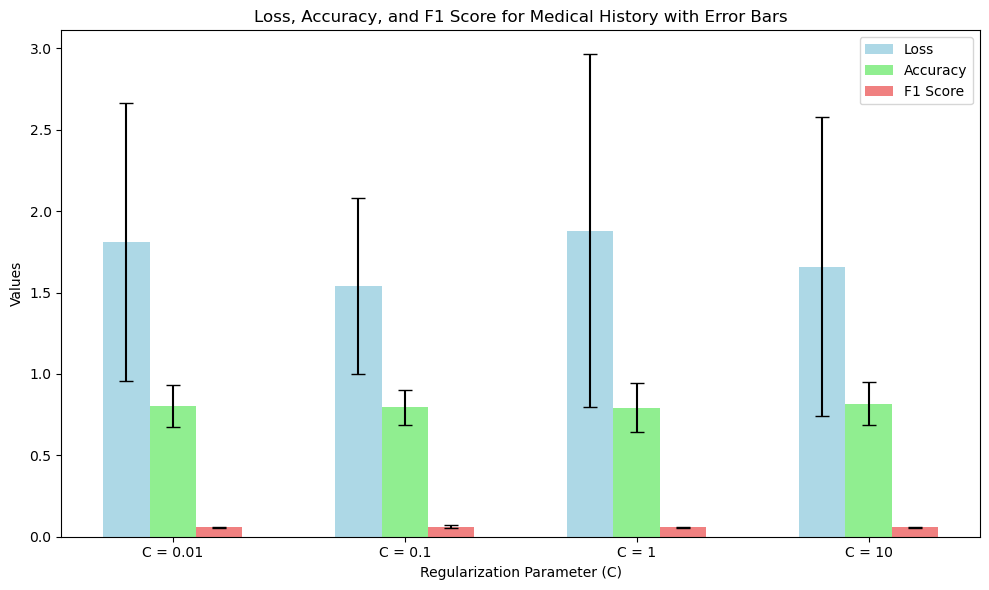

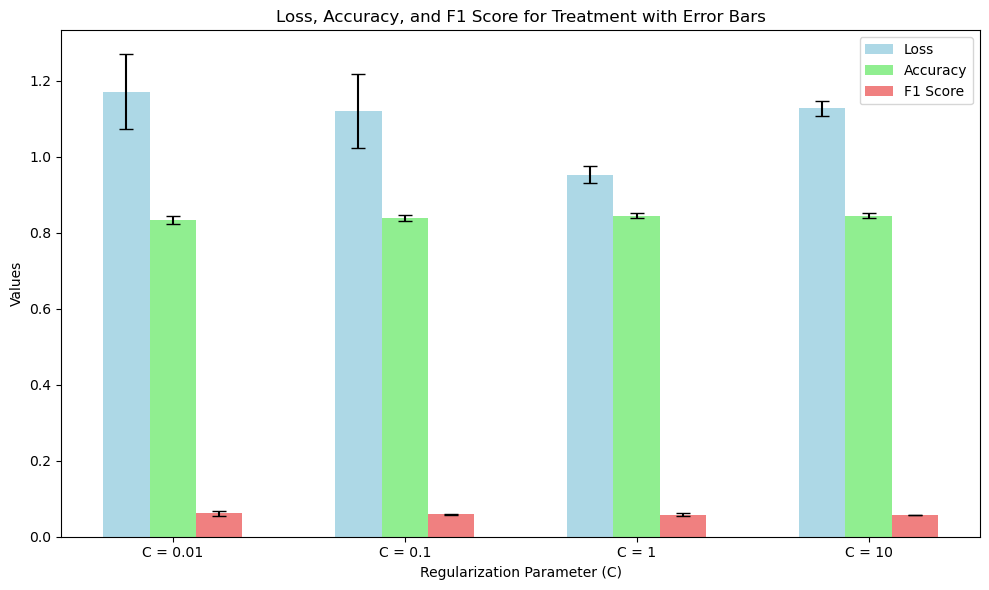

In [12]:
# List of results and corresponding labels for each dataset
results_list = [results_demographic, results_medical_history, results_treatment]
labels = ['Demographic', 'Medical History', 'Treatment']

# Regularization parameters (C values)
regularization_params = [0.01, 0.1, 1, 10]

# Create a loop to generate plots for each result
for i, results in enumerate(results_list):
    # Calculate mean and standard deviation for losses, accuracies, and F1 scores
    means_losses = []
    std_losses = []
    means_accuracies = []
    std_accuracies = []
    means_f1_scores = []
    std_f1_scores = []
    
    for reg_param in regularization_params:
        fold_losses = results[reg_param]['fold_losses']
        fold_accuracies = results[reg_param]['fold_accuracies']
        fold_f1 = results[reg_param]['fold_f1_scores']
        
        # Mean and standard deviation for losses
        means_losses.append(np.mean(fold_losses))
        std_losses.append(np.std(fold_losses, ddof=1))  # Sample std (ddof=1)
        
        # Mean and standard deviation for accuracies
        means_accuracies.append(np.mean(fold_accuracies))
        std_accuracies.append(np.std(fold_accuracies, ddof=1))  # Sample std (ddof=1)
        
        # Mean and standard deviation for F1 scores
        means_f1_scores.append(np.mean(fold_f1))
        std_f1_scores.append(np.std(fold_f1, ddof=1))  # Sample std (ddof=1)

    # Create positions for grouped bars
    width = 0.2  # Width of each bar group
    positions = np.arange(len(regularization_params))

    # Adjust positions for each metric (losses, accuracies, F1 scores)
    pos_losses = positions - width  # Shift left
    pos_accuracies = positions      # Center
    pos_f1_scores = positions + width  # Shift right

    # Plot combined bar chart with legend for each result set
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot for losses
    ax.bar(pos_losses, means_losses, yerr=std_losses, capsize=5, width=width, label='Loss', color='lightblue')

    # Plot for accuracies
    ax.bar(pos_accuracies, means_accuracies, yerr=std_accuracies, capsize=5, width=width, label='Accuracy', color='lightgreen')

    # Plot for F1 scores
    ax.bar(pos_f1_scores, means_f1_scores, yerr=std_f1_scores, capsize=5, width=width, label='F1 Score', color='lightcoral')

    # Set labels and title
    ax.set_xlabel("Regularization Parameter (C)")
    ax.set_ylabel("Values")
    ax.set_title(f"Loss, Accuracy, and F1 Score for {labels[i]} with Error Bars")

    # Set x-ticks
    ax.set_xticks(positions)
    ax.set_xticklabels([f"C = {param}" for param in regularization_params])

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


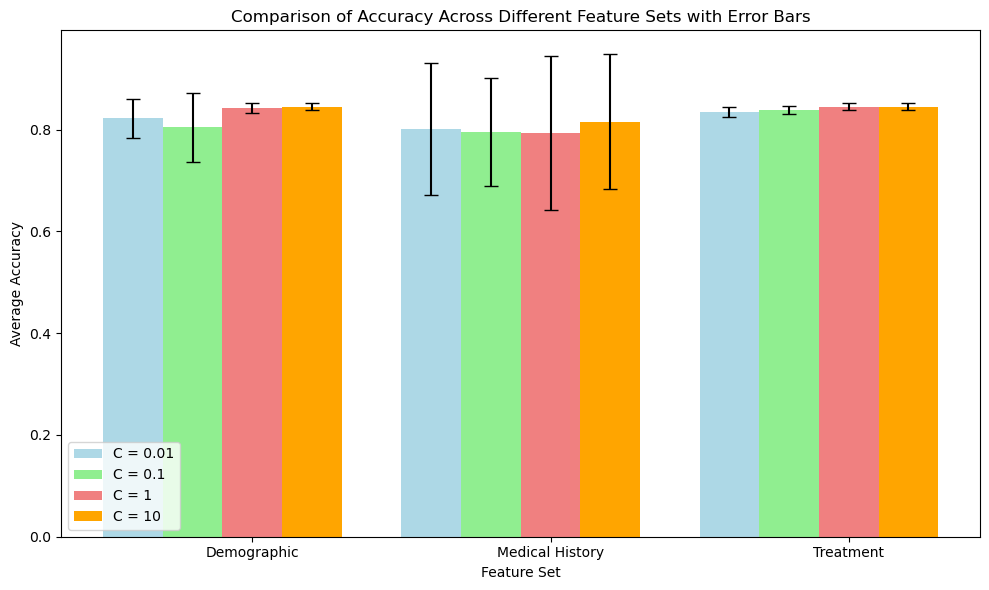

In [14]:
# List of results and labels for the three datasets
results_list = [results_demographic, results_medical_history, results_treatment]
labels = ['Demographic', 'Medical History', 'Treatment']


regularization_params = [0.01, 0.1, 1, 10]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange']  # Colors for each regularization parameter

# Calculate mean accuracies and standard deviations for each result set
means_accuracies_per_result = []
std_accuracies_per_result = []

for results in results_list:
    means_accuracies = []
    std_accuracies = []
    
    for reg_param in regularization_params:
        fold_accuracies = results[reg_param]['fold_accuracies']
        means_accuracies.append(np.mean(fold_accuracies))
        std_accuracies.append(np.std(fold_accuracies, ddof=1))  # Sample std (ddof=1)
    
    means_accuracies_per_result.append(means_accuracies)
    std_accuracies_per_result.append(std_accuracies)

# Create positions for grouped bars
width = 0.2  # Width of each bar
positions = np.arange(len(labels))  # X-axis positions for each result set

# Plot the comparison of accuracies across different feature sets
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each regularization parameter with error bars
for i, reg_param in enumerate(regularization_params):
    # Adjust positions for each regularization parameter
    pos = positions + (i - len(regularization_params)/2) * width
    
    # Plot bars with error bars (standard deviation)
    ax.bar(pos, 
           [acc[i] for acc in means_accuracies_per_result], 
           yerr=[std[i] for std in std_accuracies_per_result],  # Error bars
           width=width, 
           label=f'C = {reg_param}', 
           color=colors[i], 
           capsize=5)  # capsize for error bar lines

# Set labels and title
ax.set_xlabel("Feature Set")
ax.set_ylabel("Average Accuracy")
ax.set_title("Comparison of Accuracy Across Different Feature Sets with Error Bars")

# Set x-ticks
ax.set_xticks(positions)
ax.set_xticklabels(labels)

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


Do the same for medical history and Treatment

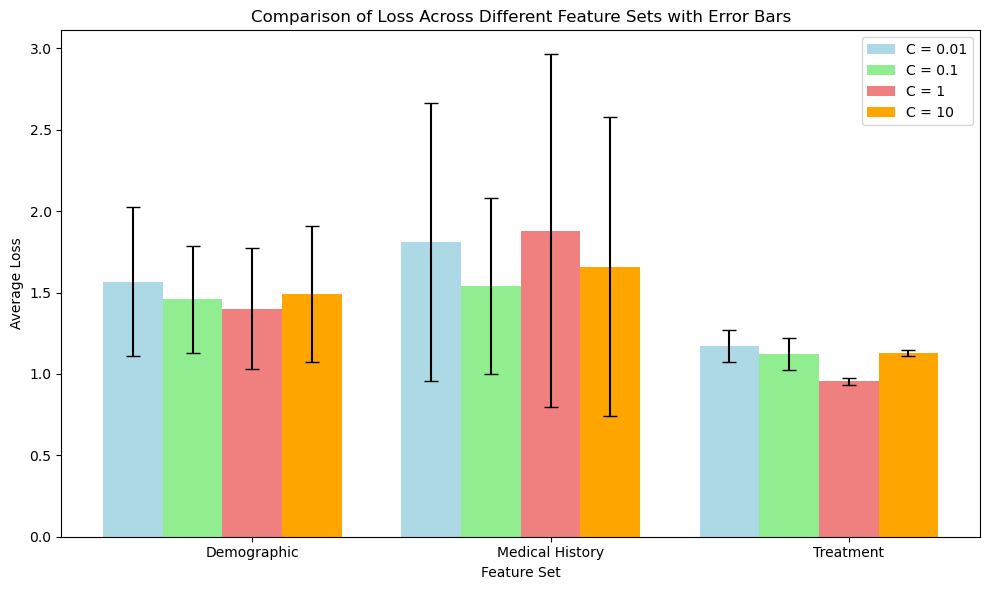

In [15]:

results_list = [results_demographic, results_medical_history, results_treatment]
labels = ['Demographic', 'Medical History', 'Treatment']


regularization_params = [0.01, 0.1, 1, 10]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange']  


means_losses_per_result = []
std_losses_per_result = []

for results in results_list:
    means_losses = []
    std_losses = []
    
    for reg_param in regularization_params:
        fold_losses = results[reg_param]['fold_losses']
        means_losses.append(np.mean(fold_losses))
        std_losses.append(np.std(fold_losses, ddof=1))  # Sample std (ddof=1)
    
    means_losses_per_result.append(means_losses)
    std_losses_per_result.append(std_losses)


width = 0.2  
positions = np.arange(len(labels))  


fig, ax = plt.subplots(figsize=(10, 6))


for i, reg_param in enumerate(regularization_params):
    pos = positions + (i - len(regularization_params)/2) * width
    
    ax.bar(pos, 
           [loss[i] for loss in means_losses_per_result], 
           yerr=[std[i] for std in std_losses_per_result],  # Error bars
           width=width, 
           label=f'C = {reg_param}', 
           color=colors[i], 
           capsize=5)  


ax.set_xlabel("Feature Set")
ax.set_ylabel("Average Loss")
ax.set_title("Comparison of Loss Across Different Feature Sets with Error Bars")


ax.set_xticks(positions)
ax.set_xticklabels(labels)


ax.legend()


plt.tight_layout()
plt.show()


In [80]:
mean_loss_results = []
for i in means_losses_per_result:
    mean_loss_results.append(np.mean(i))

In [81]:
mean_loss_results

[1.436128380894661, 1.6073385424911977, 1.0748891703784467]

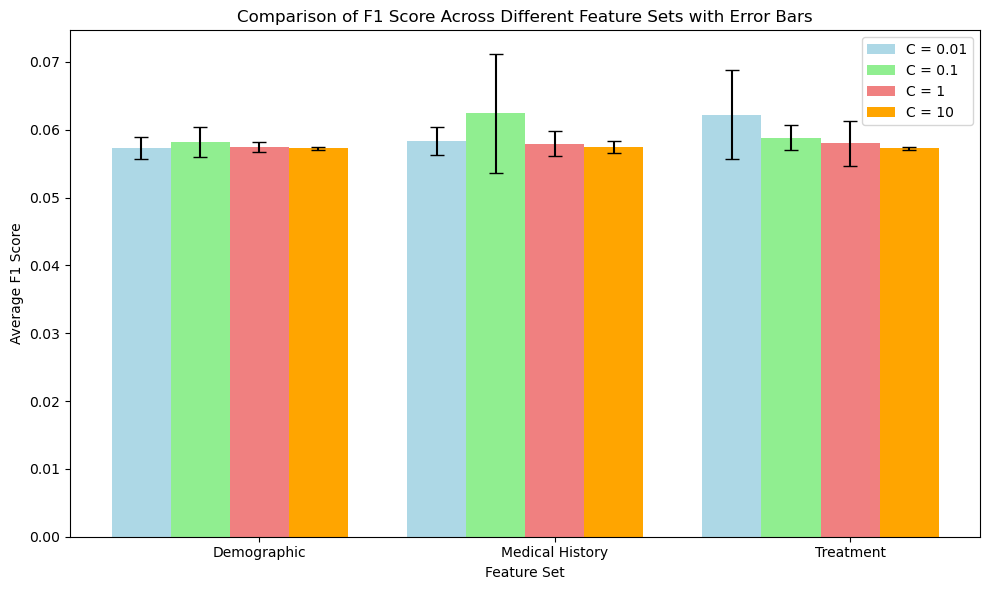

In [16]:
results_list = [results_demographic, results_medical_history, results_treatment]
labels = ['Demographic', 'Medical History', 'Treatment']


regularization_params = [0.01, 0.1, 1, 10]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'orange']  

means_f1_scores_per_result = []
std_f1_scores_per_result = []

for results in results_list:
    means_f1_scores = []
    std_f1_scores = []
    
    for reg_param in regularization_params:
        fold_f1_scores = results[reg_param]['fold_f1_scores']
        means_f1_scores.append(np.mean(fold_f1_scores))
        std_f1_scores.append(np.std(fold_f1_scores, ddof=1))  # Sample std (ddof=1)
    
    means_f1_scores_per_result.append(means_f1_scores)
    std_f1_scores_per_result.append(std_f1_scores)

width = 0.2 
positions = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(10, 6))

for i, reg_param in enumerate(regularization_params):

    pos = positions + (i - len(regularization_params)/2) * width

    ax.bar(pos, 
           [f1[i] for f1 in means_f1_scores_per_result], 
           yerr=[std[i] for std in std_f1_scores_per_result], 
           width=width, 
           label=f'C = {reg_param}', 
           color=colors[i], 
           capsize=5) 


ax.set_xlabel("Feature Set")
ax.set_ylabel("Average F1 Score")
ax.set_title("Comparison of F1 Score Across Different Feature Sets with Error Bars")


ax.set_xticks(positions)
ax.set_xticklabels(labels)

ax.legend()

plt.tight_layout()
plt.show()


In [17]:
mean_f1_results = []
for i in means_f1_scores_per_result:
    mean_f1_results.append(np.mean(i))
    
mean_f1_results

[0.05755692658804353, 0.059024544887371286, 0.05906821431143928]

Looking at the three charts for accuracy, loss, and F1 score, here's how we can analyze the performance of each subset (Demographic, Medical History, and Treatment). Treatment subset seems to be the best choice out of the three as it demonstrated relatively high accuracy and F1-score as well as low loss. Using the accuracy metric, the most suitable regularisation parameter to use would be C = 10, as it shows highest accuracy with very low variance. This makes sense since the higher the parameter, the more likely it is to underfit the data. Since, the data in this instance is heavily skewed towards being 0 days in hospital, the model chose a parameter that penalises complex patterns and in essence becomes a 0R model, thus producing better accuracy.   


In [27]:
X_train.getshape

tensor([[ 1.0000,  0.0000,  1.0000,  ...,  2.0000,  2.0000,  0.0000],
        [ 0.0000,  0.0000, 12.0000,  ..., 12.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000, 10.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  1.0000,  ..., 12.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  9.0000,  ...,  6.5000, 10.0000,  0.0000],
        [ 1.0000,  0.0000,  1.0000,  ...,  1.0000,  5.0000,  0.0000]])

## Test Model

In [43]:
X_test_treatment = test_data_df[treatment_features]
X_test_treatment = torch.tensor(X_test_treatment.values, dtype=torch.float32)
X_train = X_train_treatment
X_test = X_test_treatment

In [49]:
# Get the number of features and classes
n_samples, n_features = X_test.shape

In [50]:
model = LogisticRegression(n_features, n_classes)

In [51]:
# Loss and optimizer
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [52]:
import time

model = LogisticRegression(n_features, n_classes)

best_param = 10
# Loss and optimizer
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=best_param)
softmax = torch.nn.Softmax(dim=1)

num_epochs = 100
LOG_INTERVAL = 10  # Log stats every 10 epochs

# For tracking the metrics over time
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

start_time = time.time()

for epoch in range(num_epochs):
    # Forward pass: calculate predictions and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train)
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    # Calculate training accuracy
    predictions = torch.argmax(y_predicted, dim=1)
    train_acc = torch.eq(predictions, y_train).float().mean().item()
    
    # Store training loss and accuracy
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    
    # Every LOG_INTERVAL, log the stats
    if (epoch + 1) % LOG_INTERVAL == 0:
        deltaT = time.time() - start_time
        mean_loss = sum(train_losses[-LOG_INTERVAL:]) / LOG_INTERVAL
        mean_acc = sum(train_accuracies[-LOG_INTERVAL:]) / LOG_INTERVAL
        print(f'[TRAIN] Epoch {epoch+1} | Mean loss: {mean_loss:.4f} | Train accuracy: {mean_acc:.4f} | Time: {deltaT:.2f}s')
    
    # Test the model after each epoch
    with torch.no_grad():
        test_preds, test_labels = [], []
        test_loss = 0.

        for i in range(len(X_test)):
            x_test = X_test[i].unsqueeze(0)  # Get individual test sample (and add batch dimension)
            labels = y_test[i].unsqueeze(0)  # Get corresponding label
            
            logits = model(x_test)  # Forward pass through the model
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(logits, labels).item()  # Compute loss
            
            
            test_preds.append(predictions)
            test_labels.append(labels)

        # Concatenate all predictions and labels for accuracy computation
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        # Calculate test accuracy
        test_acc = torch.eq(test_preds, test_labels).float().mean().item()

    # Log test loss and accuracy
    print(f'[TEST] Test loss: {test_loss/len(X_test):.4f} | Test accuracy: {test_acc:.4f}')
    
    # **Store the test accuracy and test loss for plotting later**
    test_losses.append(test_loss / len(X_test))
    test_accuracies.append(test_acc)

# After training, you can now plot `train_losses`, `train_accuracies`, `test_losses`, and `test_accuracies`.


[TEST] Test loss: 10.5046 | Test accuracy: 0.0690
[TEST] Test loss: 6.7664 | Test accuracy: 0.3095
[TEST] Test loss: 5.0522 | Test accuracy: 0.4925
[TEST] Test loss: 4.3338 | Test accuracy: 0.5810
[TEST] Test loss: 3.9537 | Test accuracy: 0.6261
[TEST] Test loss: 3.7060 | Test accuracy: 0.6523
[TEST] Test loss: 3.5196 | Test accuracy: 0.6713
[TEST] Test loss: 3.3651 | Test accuracy: 0.6850
[TEST] Test loss: 3.2291 | Test accuracy: 0.6953
[TRAIN] Epoch 10 | Mean loss: 6.9127 | Train accuracy: 0.4440 | Time: 27.22s
[TEST] Test loss: 3.1049 | Test accuracy: 0.7046
[TEST] Test loss: 2.9891 | Test accuracy: 0.7120
[TEST] Test loss: 2.8797 | Test accuracy: 0.7185
[TEST] Test loss: 2.7756 | Test accuracy: 0.7249
[TEST] Test loss: 2.6760 | Test accuracy: 0.7307
[TEST] Test loss: 2.5807 | Test accuracy: 0.7364
[TEST] Test loss: 2.4896 | Test accuracy: 0.7423
[TEST] Test loss: 2.4028 | Test accuracy: 0.7475
[TEST] Test loss: 2.3202 | Test accuracy: 0.7504
[TEST] Test loss: 2.2421 | Test accuracy

In [83]:
test_preds

tensor([0, 0, 0,  ..., 0, 0, 0])

In [39]:
from sklearn.metrics import roc_auc_score

softmax = torch.nn.Softmax(dim=1)

predictions = torch.argmax(logits, dim=1)
# After making predictions with your model, where `y_pred_probs` are the predicted probabilities
y_pred_probs = softmax(model(X_test)).detach().numpy()  # Get probabilities from the softmax layer
y_test_numpy = y_test.detach().numpy()  # True labels
y_pred_numpy = test_preds.detach().numpy()

# Compute AUC ROC using one-vs-rest strategy
roc_auc = roc_auc_score(y_test_numpy, y_pred_probs, multi_class='ovr')
precision = precision_score(y_test_numpy, y_pred_numpy, zero_division=1, average="micro")
recall = recall_score(y_test_numpy, y_pred_numpy, zero_division=1, average="macro")

print(f"AUC ROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC ROC: 0.3942
Precision: 0.8379
Recall: 0.0630


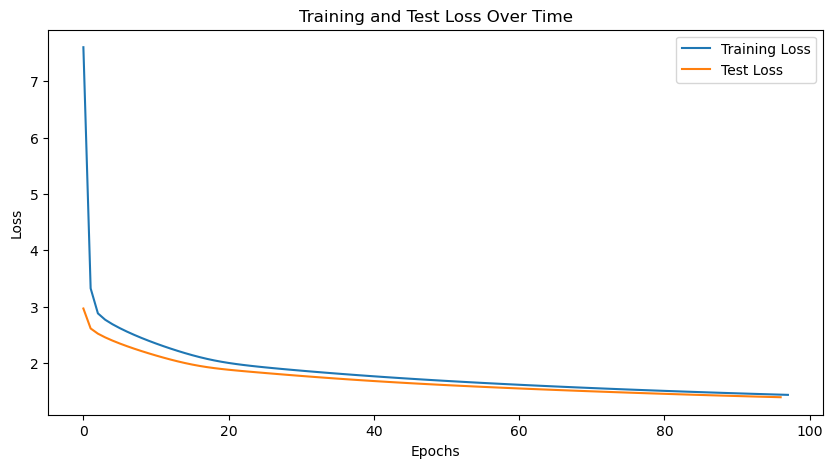

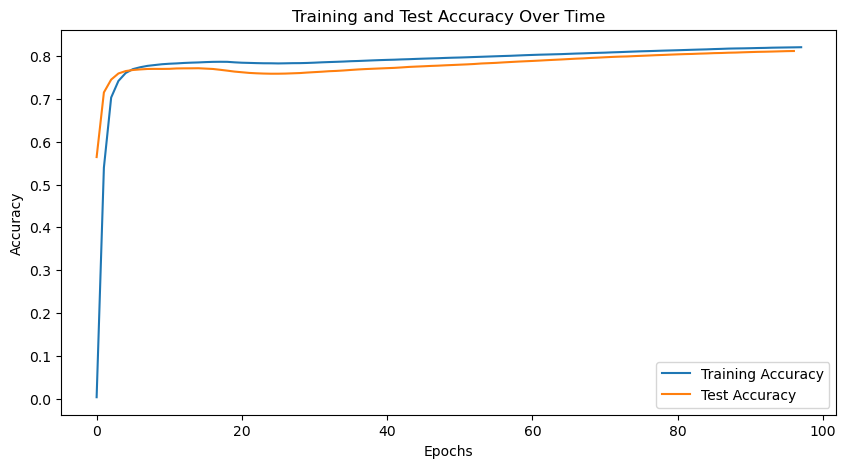

In [63]:
import matplotlib.pyplot as plt

# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.show()

# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Time')
plt.legend()
plt.show()
